In [1]:
#Streamlining workflows with pipelines
#Example using the wisconsin breast cancer database

import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                '/breast-cancer-wisconsin/wdbc.data',
                header = None)

In [2]:
#After importing dataset - need to change the labels to integers
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

#30 features are in X
X = df.loc[:, 2:].values

#Class labels in y
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
#Example of the encoding
le.transform(['M', 'B'])

array([1, 0])

In [3]:
#Next step - separating the training from the test datasets - now using the 80-20 split
#Stratify the samples based on the y labels - not stratify = 'yes'

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                    test_size = 0.20,
                    stratify = y,
                    random_state = 1)

In [4]:
#Combining transformers and estimators in a pipeline
#Chaining StandardScaler, PCA, and LogisticRegression which all need standardization

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)

print('Test Accuracy: %.3f' %pipe_lr.score(X_test, y_test))


Test Accuracy: 0.956


In [5]:
#K-fold cross-validation for model performance
# Using stratified k-fold cross-validation makes sure that the class proportions
# are preserved

import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, 
                       random_state=1).split(X_train,
                                            y_train)

scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k + 1,
                                                    np.bincount(y_train[train]), score))


Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [6]:
print('\nCV accuracy: %.3f +/- %.3f' %
     (np.mean(scores), np.std(scores)))


CV accuracy: 0.950 +/- 0.014


In [7]:
#Less verbose version using scikit-learn

from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                        X = X_train,
                        y = y_train,
                        cv = 10,
                        n_jobs=1)

print('CV accuracy scores: %s' % scores)

#You can also distribute the jobs across different cpu cores with the n_jobs, n_jobs = -1 uses all

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [8]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                     np.std(scores)))

CV accuracy: 0.950 +/- 0.014


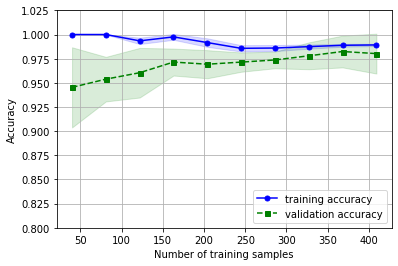

In [9]:
#Learning and validation curves
# Learning curves can be used to identify over (high variance) or underfitting (high bias)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty= 'l2',
                                         random_state=1))

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lr,
                  X = X_train,
                  y = y_train,
                  train_sizes= np.linspace(
                  0.1, 1.0, 10),
                  cv = 10,
                  n_jobs = 1)
#Training sizes=np.linspace gives 10 evenly spaced relative intervals for training set size

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean,
        color = 'blue', marker = 'o',
        markersize = 5, label = 'training accuracy')

plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean,
        color = 'green', linestyle = '--',
        marker = 's', markersize = 5,
        label = 'validation accuracy')

plt.fill_between(train_sizes,
                test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.025])
plt.show()

/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

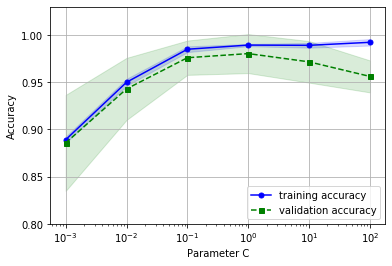

In [10]:
#Validation curve - similar to learning curve but with varying values of the parameters
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator = pipe_lr,
    X = X_train,
    y = y_train,
    param_name= 'logisticregression__C',
    param_range=param_range,
    cv = 10)

train_mean = np.mean(train_scores, axis =1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
plt.plot(param_range, train_mean,
        color = 'blue', marker = 'o',
        markersize = 5, label = 'training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                train_mean - train_std, alpha = 0.15,
                color = 'blue')
plt.plot(param_range, test_mean,
        color = 'green', linestyle = '--',
        marker = 's', markersize = 5, 
        label = 'validation accuracy')
plt.fill_between(param_range, test_mean + test_std,
                test_mean - test_std, alpha = 0.15,
                color = 'green')
plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#Underfits the data with small C (strong regularization strength)
#Overfits the data with large C (weak regularization strength)
#best at around C .01 and .1

In [11]:
#Grid search - hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C' : param_range,
              'svc__kernel': ['linear']},
             {'svc__C': param_range,
             'svc__gamma': param_range,
             'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 refit = True, 
                 cv = 10,
                 n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)


0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [12]:
clf = gs.best_estimator_

#clf.fit(X_train, y_train) this is unnecessary - already refit with the gridsearch CV

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


In [13]:
#Nested cross validation - algorithm selection is nested within the cv 
from sklearn.model_selection import cross_val_score

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                 scoring='accuracy',
                 cv = 2)

scores = cross_val_score(gs, X_train, y_train,
                        scoring = 'accuracy', cv = 5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                     np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [14]:
#Can compare the good cv accuracy of the svm with decision tree
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state= 0),
                  param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv = 2)

scores = cross_val_score(gs, X_train, y_train,
                        scoring = 'accuracy', cv = 5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                     np.std(scores)))

#This model doesnt have as high an accuracy score as the SVM - would use that instead

CV accuracy: 0.934 +/- 0.016


In [15]:
#Other performance evaluation metrics

from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


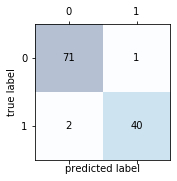

In [16]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[1]):
    for j in range(confmat.shape[0]):
        ax.text(x = j, y = i, 
                s = confmat[i, j],
                va = 'center', ha = 'center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [17]:
#Using the above information to calculate various error metrics

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(
                        y_true = y_test, y_pred=y_pred))


Precision: 0.976


In [18]:
print('Recall: %.3f' % recall_score(y_true = y_test,
                                   y_pred = y_pred))

Recall: 0.952


In [19]:
print('F1: %.3f' %f1_score(y_true = y_test,
                                   y_pred = y_pred))

F1: 0.964


In [20]:
#Creating our own scorer - change the positive from class 1

from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv = 10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9880771478667446
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


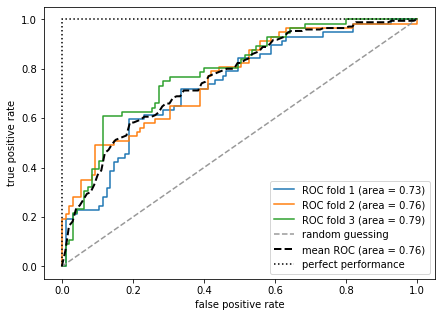

In [21]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2',
                                         random_state=1,
                                         C = 100.0))

X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3,
                         random_state=1).split(X_train,
                                              y_train))

fig = plt.figure(figsize = (7, 5))

mean_tpr = 0.0

mean_fpr = np.linspace(0, 1, 100)

all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], 
                        y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                    probas[:, 1],
                                    pos_label = 1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
            tpr,
            label = 'ROC fold %d (area = %0.2f)'
            % (i+1, roc_auc))
    
plt.plot([0, 1],
        [0, 1],
        linestyle = '--',
        color = (0.6, 0.6, 0.6),
        label = 'random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
        label = 'mean ROC (area = %0.2f)' % mean_auc, lw = 2)

plt.plot([0, 0, 1],
        [0, 1, 1],
        linestyle = ':',
        color = 'black',
        label = 'perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc = 'lower right')
plt.show()

In [27]:
#Micro-average is better if you have unbalanced classes or features
#Macroaverage is default for most functions but treats unequal classes equally 
#which may give misleading results.

pre_scorer = make_scorer(score_func=precision_score,
                        pos_label =1,
                        greater_is_better=True,
                        average = 'micro')

In [29]:
#Creating an imbalanced dataset

X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [32]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [34]:
#Using resample to upsample from the minority class (class with the fewer number of samples) - an attempt
# to deal with unbalanced class sizes

from sklearn.utils import resample

print('Number of class 1 samples before:', X_imb[y_imb == 1].shape[0])

Number of class 1 samples before: 40


In [36]:
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                   y_imb[y_imb == 1],
                                   replace = True,
                                   n_samples = X_imb[y_imb == 0].shape[0],
                                   random_state=123)
print('Number of class 1 samples after:', X_upsampled.shape[0])

Number of class 1 samples after: 357


In [37]:
#can then stack the original class 0 samples with the upsampled class 1 subset to 
#obtain balanced a dataset

X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [38]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0